In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
cd ..

/Share/home/shibinbin/projects/Deepfold2


In [14]:
import pandas as pd
import h5py
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve

In [5]:
structures = {'16S': ['16SRRNA-domain1', '16SRRNA-domain2', '16SRRNA-domain3', '16SRRNA-domain4'],
    '5S': ['5SRRNA'],
    '23S': ['23SRRNA-domain1', '23SRRNA-domain2', '23SRRNA-domain3',
            '23SRRNA-domain4', '23SRRNA-domain5', '23SRRNA-domain6'],
    'HCV_IRES': ['HCV_domain2'],
    'TPP': ['TPPribo-ecoli']
}

In [6]:
from Bio import SeqIO
# read SHAPE-MaP sequences
shapemap_sequences = {}
with open('output/patteRNA/SHAPE-MaP/model_RNAs.fa', 'r') as f:
    for record in SeqIO.parse(f, format='fasta'):
        shapemap_sequences[record.id] = str(record.seq)

In [7]:
# read SHAPE-MaP reactivities
shapemap_reactivities = {}
for rna_id in shapemap_sequences:
    df = pd.read_table('output/patteRNA/SHAPE-MaP/model_RNAs.raw/{}.map'.format(rna_id),
                    header=None, sep='\t',
                    names=('index', 'reactivity', 'stderr', 'nucleotide'))
    if (df['index'].iloc[-1] - df['index'].iloc[0] + 1) != df['index'].shape[0]:
        print('noncontigous reactivities found in {}'.format(rna_id))
    else:
        reactivities = df['reactivity'].values.copy()
        reactivities[reactivities < -100] = np.nan
        shapemap_reactivities[rna_id] = reactivities

In [8]:
# map positions in SHAPE-MaP data to RME structures
f_shape = open('output/patteRNA/SHAPE-MaP/model_RNAs_domains.shape', 'w')
f_fasta = open('output/patteRNA/SHAPE-MaP/model_RNAs_domains.fa', 'w')
f_dot = open('output/patteRNA/SHAPE-MaP/model_RNAs_domains.dot', 'w')
rme_reactivities = {}
for shapemap_id in shapemap_sequences:
    if shapemap_id not in structures:
        continue
    for rme_id in structures[shapemap_id]:
        with open('/Share/home/shibinbin/data/RME_structures/structure/{}.dot'.format(rme_id), 'r') as f:
            header = f.readline()
            rme_seq = f.readline().strip()
            rme_structure = f.readline().strip()
            shapemap_seq = shapemap_sequences[shapemap_id]
            pos = rme_seq.find(shapemap_seq)
            found = False
            if pos >= 0:
                # shapemap_seq is a substring of rme_seq
                print('{0}:{1}-{2} => {3}'.format(rme_id, pos, pos + len(shapemap_seq), shapemap_id))
                reactivities = np.full(len(rme_seq), np.nan)
                reactivities[pos:(pos + len(shapemap_seq))] = shapemap_reactivities[shapemap_id]
                f_shape.write('>{}\n'.format(rme_id))
                f_shape.write(' '.join(['%.4f'%a for a in reactivities]))
                f_shape.write('\n')
                found = True
            else:
                pos = shapemap_seq.find(rme_seq)
                if pos >= 0:
                    rme_reactivities[rme_id] = shapemap_reactivities[shapemap_id][pos:(pos + len(rme_seq))]
                    print('{0}:{1}-{2} => {3}'.format(shapemap_id, pos, pos + len(rme_seq), rme_id))
                    f_shape.write('>{}\n'.format(rme_id))
                    f_shape.write(' '.join(['%.4f'%a for a in shapemap_reactivities[shapemap_id][pos:(pos + len(rme_seq))]]))
                    f_shape.write('\n')
                    found = True
            if found:
                f_dot.write('>{}\n'.format(rme_id))
                f_dot.write(shapemap_sequences[shapemap_id][pos:(pos + len(rme_seq))])
                f_dot.write('\n')
                f_dot.write(rme_structure)
                f_dot.write('\n')
                f_fasta.write('>{}\n'.format(rme_id))
                f_fasta.write(shapemap_sequences[shapemap_id][pos:(pos + len(rme_seq))])
                f_fasta.write('\n')
f_shape.close()
f_dot.close()
f_fasta.close()

23S:0-562 => 23SRRNA-domain1
23S:562-1270 => 23SRRNA-domain2
23S:1270-1646 => 23SRRNA-domain3
23S:1646-2015 => 23SRRNA-domain4
23S:2015-2625 => 23SRRNA-domain5
23S:2625-2904 => 23SRRNA-domain6
HCV_IRES:0-95 => HCV_domain2
TPPribo-ecoli:0-79 => TPP
16S:0-561 => 16SRRNA-domain1
16S:561-916 => 16SRRNA-domain2
16S:916-1396 => 16SRRNA-domain3
16S:1396-1542 => 16SRRNA-domain4
5SRRNA:20-140 => 5S


In [37]:
# map positions in SHAPE-MaP data to RNA structure archive
import os
RNA_archive_dir = '/Share/home/shibinbin/data/RNA_structures/sequence'
shapemap_id = 'Group_I'
for seq_file in os.listdir(RNA_archive_dir):
    if seq_file.startswith('grp1_a'):
        with open(RNA_archive_dir + '/' + seq_file, 'r') as f:
            for record in SeqIO.parse(f, format='fasta'):
                archive_name = os.path.splitext(seq_file)[0]
                archive_seq = str(record.seq)
                break
            shapemap_seq = shapemap_sequences[shapemap_id]
            pos = archive_seq.find(shapemap_seq)
            if pos >= 0:
                # shapemap_seq is a substring of rme_seq
                print('{0}:{1}-{2} => {3}'.format(archive_id, pos, pos + len(shapemap_seq), shapemap_id))
            else:
                pos = shapemap_seq.find(archive_seq)
                if pos >= 0:
                    print('{0}:{1}-{2} => {3}'.format(shapemap_id, pos, pos + len(archive_seq), archive_id))

In [9]:
# read patteRNA posteriors
def read_patteRNA_posteriors(filename):
    posteriors1 = {}
    posteriors2 = {}
    with open(filename, 'r') as f:
        for lineno, line in enumerate(f):
            if lineno%3 == 0:
                name = line[1:].strip()
            elif lineno%3 == 1:
                posteriors1[name] = np.asarray(line.strip().split(), dtype=np.float32)
            elif lineno%3 == 2:
                posteriors2[name] = np.asarray(line.strip().split(), dtype=np.float32)
    return posteriors1, posteriors2

def read_patteRNA_viterbi(filename):
    viterbi = {}
    with open(filename, 'r') as f:
        for lineno, line in enumerate(f):
            if lineno%2 == 0:
                name = line[1:].strip()
            elif lineno%2 == 1:
                viterbi[name] = np.asarray(list(line.strip()), dtype='S1').astype(np.int32)
    return viterbi

posteriors1, posteriors2 = read_patteRNA_posteriors('output/patteRNA/SHAPE-MaP/model_RNAs.output/posteriors.txt')
viterbi = read_patteRNA_viterbi('output/patteRNA/SHAPE-MaP/model_RNAs.output/viterbi.txt')

In [10]:
# read structures from dot files
def read_dot(filename):
    records = []
    with open(filename, 'r') as f:
        for lineno, line in enumerate(f):
            if lineno%3 == 0:
                name = line[1:].strip()
            elif lineno%3 == 1:
                seq = line.strip()
            else:
                structure = line.strip()
                records.append((name, seq, structure))
    return records
shapemap_structures = {}
for name, seq, structure in read_dot('output/patteRNA/SHAPE-MaP/model_RNAs.dot'):
    shapemap_structures[name] = structure

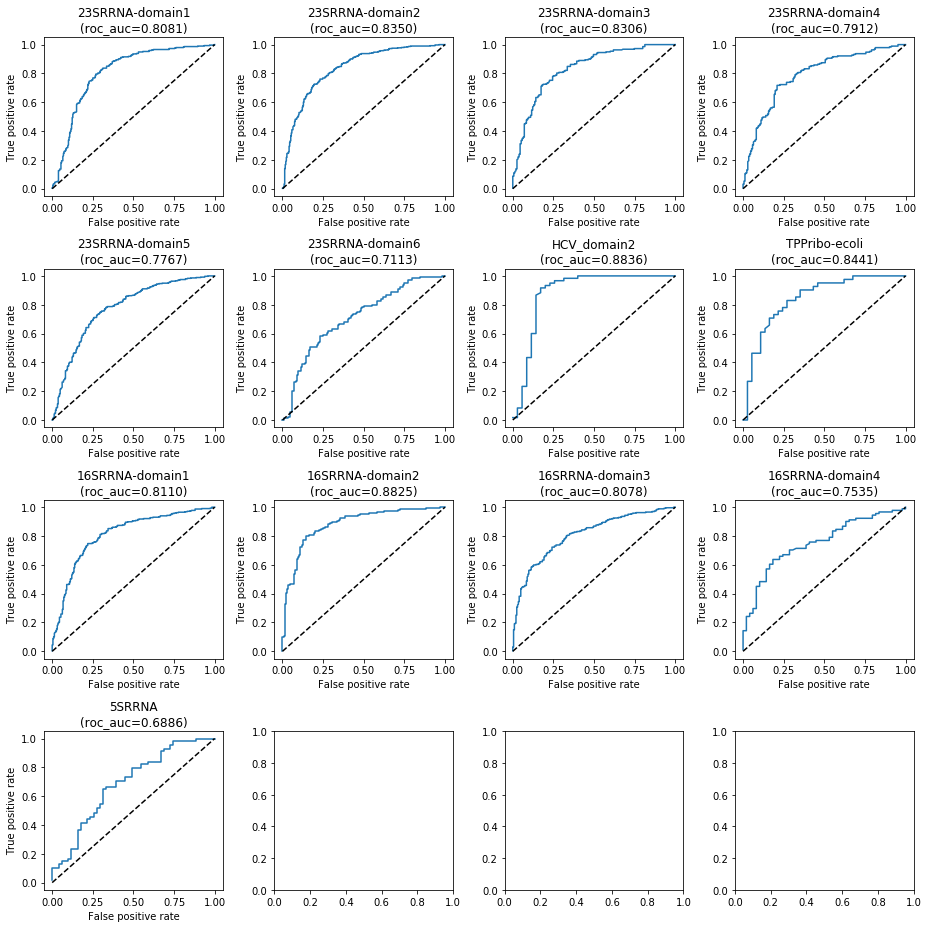

In [26]:
# ROC curves of SHAPE-MaP reactivities
with h5py.File('output/patteRNA/SHAPE-MaP/model_RNAs_domains.reactivities.h5', 'r') as f:
    reactivities = {name:f[name][:] for name in f.keys()}
structures = {}
for name, seq, structure in read_dot('output/patteRNA/SHAPE-MaP/model_RNAs_domains.dot'):
    structures[name] = (np.frombuffer(bytearray(structure, encoding='ascii'), dtype='S1') != b'.').astype(np.int32)
n_cols = 4
fig, axes = plt.subplots(int(np.ceil(len(structures)/n_cols)), n_cols, figsize=(13, 13))
for k, name in enumerate(structures):
    notnan_mask = ~np.isnan(reactivities[name])
    fpr, tpr, thresholds = roc_curve(structures[name][notnan_mask], -reactivities[name][notnan_mask])
    roc_auc = roc_auc_score(structures[name][notnan_mask], -reactivities[name][notnan_mask])
    ax = axes[k//n_cols, k%n_cols]
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='k', linestyle='dashed')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('{}\n(roc_auc={:.4f})'.format(name, roc_auc))
plt.tight_layout()
#print(roc_auc)

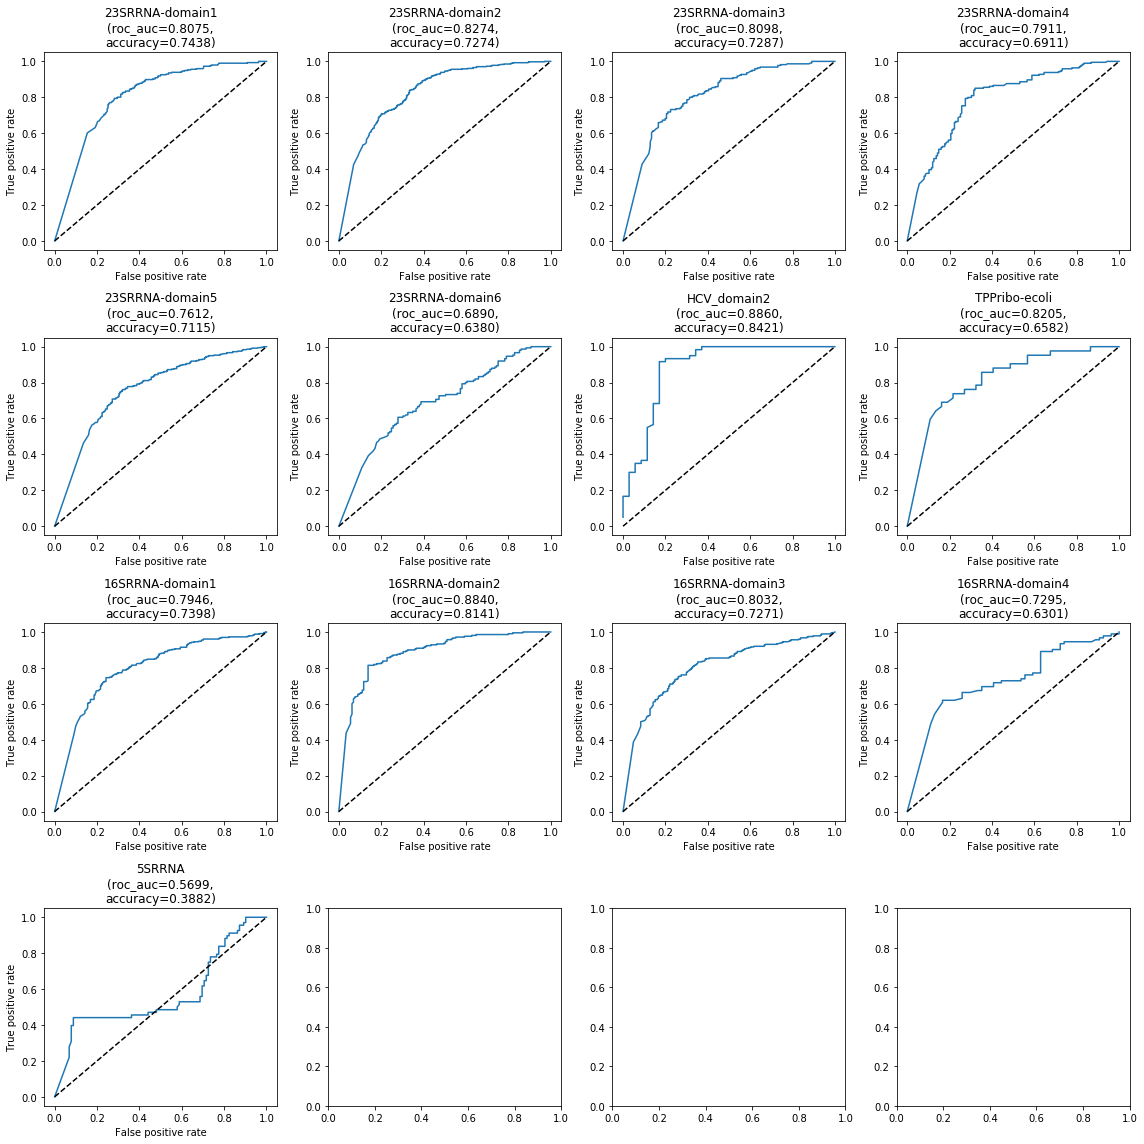

In [16]:
# ROC curves of SHAPE-MaP reactivities
with h5py.File('output/patteRNA/SHAPE-MaP/model_RNAs_domains.posteriors_paired.h5', 'r') as f:
    posteriors_paired = {name:f[name][:] for name in f.keys()}
with h5py.File('output/patteRNA/SHAPE-MaP/model_RNAs_domains.viterbi.h5', 'r') as f:
    viterbi = {name:f[name][:] for name in f.keys()}
structures = {}
for name, seq, structure in read_dot('output/patteRNA/SHAPE-MaP/model_RNAs_domains.dot'):
    structures[name] = (np.frombuffer(bytearray(structure, encoding='ascii'), dtype='S1') != b'.').astype(np.int32)
# plot patteRNA posteriors with structures
fig, axes = plt.subplots(int(np.ceil(len(structures)/4)), 4, figsize=(16, 16))
for k, name in enumerate(structures):
    roc_auc = roc_auc_score(structures[name], posteriors_paired[name])
    accuracy = accuracy_score(structures[name], viterbi[name])
    fpr, tpr, thresholds = roc_curve(structures[name], posteriors_paired[name])
    ax = axes[k//4, k%4]
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='k', linestyle='dashed')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('{}\n(roc_auc={:.4f},\naccuracy={:.4f})'.format(name, roc_auc, accuracy))
plt.tight_layout()
#print(roc_auc)

In [232]:
def pulses_to_square(signals):
    is_edge = ~np.isclose(signals[1:] - signals[:-1], 0)
    L = signals.shape[0] + np.sum(is_edge) + 1
    y = np.zeros(L, dtype=signals.dtype)
    x = np.zeros(L, dtype=np.int64)
    j = 1
    x[0] = 0
    y[0] = signals[0]
    for i in range(signals.shape[0] - 1):
        x[j] = i + 1
        y[j] = signals[i]
        j += 1
        if is_edge[i]:
            x[j] = i + 1
            y[j] = signals[i + 1]
            j += 1
    x[j] = signals.shape[0]
    y[j] = signals[-1]
    return x, y

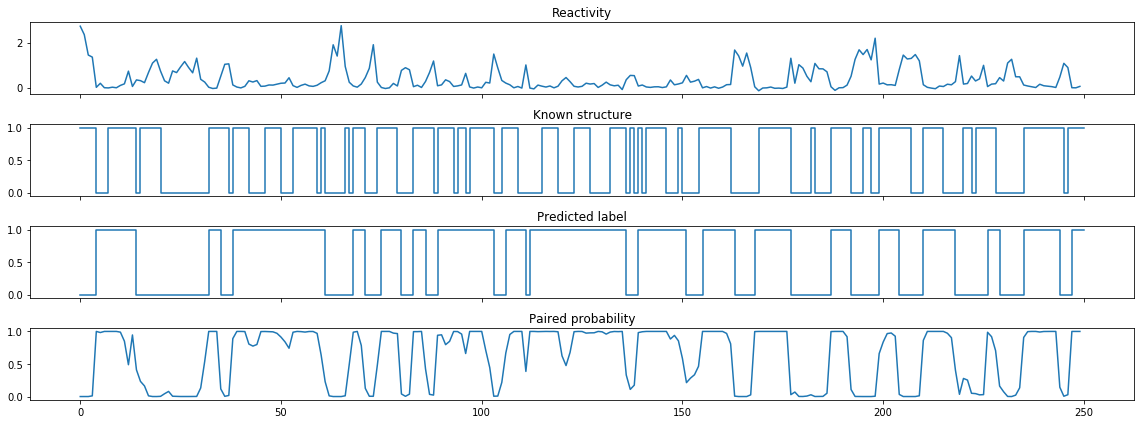

In [251]:
seq_name = '16SRRNA-domain1'
start, end = 300, 550
fig, axes = plt.subplots(4, 1, figsize=(16, 6), sharex=True)
axes[0].plot(reactivities[seq_name][start:end])
axes[0].set_title('Reactivity')
axes[1].plot(*pulses_to_square(structures[seq_name][start:end]))
axes[1].set_title('Known structure')
axes[2].plot(*pulses_to_square(viterbi[seq_name][start:end]))
axes[2].set_title('Predicted label')
axes[3].plot(posteriors_paired[seq_name][start:end])
axes[3].set_title('Paired probability')
plt.tight_layout()
pass

In [137]:
b == b'A'

array([False, False, False, False, False])

In [150]:
b = np.asarray(list('ATCG'))
b

array(['A', 'T', 'C', 'G'], dtype='<U1')

In [149]:
b[0]

'A'

In [171]:
b = np.frombuffer(b'abcde', dtype='S1')
type(b[0])

numpy.bytes_

In [164]:
bytes(b'abcde')

b'abcde'

In [167]:
b.astype('U')

array(['a', 'b', 'c', 'd', 'e'], dtype='<U1')

In [194]:
np.frombuffer(bytearray('abcde', encoding='ascii'), dtype='S1')

array([b'a', b'b', b'c', b'd', b'e'], dtype='|S1')

In [181]:
bytes('abcde', encoding='ascii')

b'abcde'

In [189]:
np.frombuffer('abcde', dtype='S1')

AttributeError: 'str' object has no attribute '__buffer__'

In [190]:
str.__buffer__

AttributeError: type object 'str' has no attribute '__buffer__'

In [197]:
np.asarray(list('ATCG')).astype('S')

array([b'A', b'T', b'C', b'G'], dtype='|S1')

In [199]:
viterbi = {}
import h5py
with h5py.File('output/patteRNA/SHAPE-MaP/Cell_2018_cellfree_SHAPE.viterbi.h5', 'r') as f:
    for name in f.keys():
        viterbi[name] = f[name][:]

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [204]:
viterbi_values = np.concatenate(list(viterbi.values()))

In [207]:
values, counts = np.unique(viterbi_values, return_counts=True)
print(values, counts/counts.sum())

[0 1] [0.18479683 0.81520317]


In [210]:
t = type(read_dot)

In [212]:
t.__name__

'function'

In [213]:
isinstance(read_dot, function)

NameError: name 'function' is not defined

In [215]:
read_dot.__module__

'__main__'

numpy.ufunc